In [1]:
import sys
import os

# Add the project directory of "tests" to sys.path
sys.path.append(os.path.abspath("/Users/workspace/Software/Layered_Tank_Simulation/CherenkovSim/"))

In [2]:
from cherenkov_sim.particle import Particle
from cherenkov_sim.muon import Muon
from cherenkov_sim.electron import Electron
from cherenkov_sim.gamma import Gamma
from cherenkov_sim.material import Material
from cherenkov_sim.tracker import ParticleTracker, MuonTracker, GammaTracker
from cherenkov_sim.constants import ALPHA, R_TANK, H_TANK, TOP_TANK, ELECTRON_MASS, MUON_MASS


In [3]:
import ROOT
import numpy as np 
import matplotlib as mpl
from matplotlib import pyplot as plt
import astropy.units as u

In [4]:
ice = Material(
    name = 'Ice',
    Z_A = 0.55509 * u.mol / u.g,
    rho = 0.9180 * u.g / u.cm**3,
    I = 79.7 * u.eV, 
    n = 1.309,
    X0 = 39.31 * u.cm, 
    delta_file = '/Users/workspace/Software/PHYS-F-420/lesson2/delta_elec.txt',
    att_file = '/Users/workspace/Software/Layered_Tank_Simulation/CherenkovSim/cherenkov_sim/water_gamma_cross_section.txt'
)

water = Material(
    name = 'water',
    Z_A = 0.55509 * u.mol / u.g,
    rho = 1 * u.g / u.cm**3,
    I = 79.7 * u.eV,
    n = 1.333,
    X0 = 36.08 * u.cm, 
    delta_file = '/Users/workspace/Software/PHYS-F-420/lesson2/delta_elec.txt',
    att_file = '/Users/workspace/Software/Layered_Tank_Simulation/CherenkovSim/cherenkov_sim/water_gamma_cross_section.txt'
)

In [5]:
df = ROOT.RDataFrame("randomParticles", "/Users/workspace/Software/Layered_Tank_Simulation/CORSIKA_tree/allpart.root")

In [6]:
all_lept_filter = '(fSecondaryType==1 || fSecondaryType==2 || fSecondaryType==3 || fSecondaryType==5 || fSecondaryType==6)'


In [7]:
var = df.Filter(all_lept_filter).AsNumpy(['fSecondaryType','fPx','fPy','fPz'])

sec_type = var['fSecondaryType']
px = var['fPx']
py = var['fPy']
pz = var['fPz']

In [8]:
conditions = [
    (sec_type == 1),
    (np.isin(sec_type, [2,3]) ),
    (np.isin(sec_type, [5,6]) ),
]

labels = np.array(['Gamma' , 'Electron', 'Muon'], dtype=object)

type_string = np.select(conditions, labels, default="Unknown")

mass = np.select(conditions, [0 , ELECTRON_MASS.to(u.GeV), MUON_MASS.to(u.GeV)])

ptot = np.sqrt(px**2 + py**2 + pz**2) 
etot = np.sqrt(mass*mass + ptot*ptot)

theta = np.arccos(pz/ptot)
phi = np.arctan2(px,py)


In [9]:
# Gen. surface radius 
R_gen = 200 * u.cm 
Z_gen = 140 
 
def rnd_tank_start(R_gen, N_event): 
    r = R_gen * np.sqrt(np.random.uniform(0,1,size=N_event))
    alpha = np.random.uniform(0,2*np.pi, size=N_event) 
    z_value = Z_gen 
    x0 = r * np.cos(alpha)   
    y0 = r * np.sin(alpha)  
    z0 = np.full(N_event,z_value) * u.cm
    return x0, y0, z0  



In [10]:
# Extract secondary particles randomly and throw them on the tank 
# Randomly generate particle positions 

N_PARTICLES = 1e2

N_tot = len(sec_type)
x0,y0,z0 = rnd_tank_start(R_gen, N_tot)  

N_particle = int(N_PARTICLES) # Choose number of particles to throw 
particle_id = np.random.randint(1, N_tot, size=N_particle)  # Generates N random int numbers

In [11]:
photons_mu_z = []
photons_mu_r = []
photons_mu_coor = []
mu_number = []

photons_e_z = []
photons_e_r = []
photons_e_coor = []
e_number = []

photons_gamma_z = []
photons_gamma_r = []
photons_gamma_coor = []
gamma_number = []

N_photons_mu = []
N_photons_e = []
N_photons_gamma = []

N_photons_top_mu = []
N_photons_top_e = []
N_photons_top_gamma = []


N_photons_bottom_mu = []
N_photons_bottom_e = []
N_photons_bottom_gamma = []

path_length_muon = []
path_length_e = []
path_length_e_Compton = []

path_length_gamma = []

In [12]:
counter = 0

for part_id in particle_id:

    counter += 1

    part_type = type_string[part_id]
    part_theta = theta[part_id] * u.rad 
    part_phi = phi[part_id] * u.rad
    part_etot = etot[part_id] * u.GeV

    if(counter % 1 == 0):
        print('Particle number ',counter)
        print(part_type+' with energy ',part_etot)

    initial_position = np.array([x0[part_id].value,y0[part_id].value,z0[part_id].value]) * u.cm

    if(part_type == 'Muon'):
        muon = Muon(energy = part_etot)

        # Create the Tracker
        tracker = MuonTracker(muon, water, step_size= - 1.0 * u.cm,
                        position=initial_position, 
                        zenith=part_theta, 
                        azimuth=part_phi,
                        is_landau=False)
    
        tracker.propagate(lambda1 = 300 * u.nm, lambda2 = 600 * u.nm)

        ph_z = np.asarray(tracker.cherenkov_photons_z)

        photons_mu_z.extend(tracker.cherenkov_photons_z)
        photons_mu_r.extend(tracker.cherenkov_photons_r)
        photons_mu_coor.extend(tracker.cherenkov_photons)
        N_photons_mu.append(len(tracker.cherenkov_photons_z))
        mu_number.extend(np.full(len(tracker.cherenkov_photons),counter))

        top_mask = np.logical_and(ph_z > TOP_TANK.value, ph_z < H_TANK.value)
        bottom_mask = np.logical_and(ph_z < TOP_TANK.value, ph_z > 0)
        N_photons_top_mu.append(len(ph_z[top_mask]))
        N_photons_bottom_mu.append(len(ph_z[bottom_mask]))

        path_length_muon.append(tracker.path_length)


    elif(part_type == 'Electron'):
        electron = Electron(energy = part_etot)
        electron.load_delta_parameter(water)

        # Create the Tracker
        tracker = ParticleTracker(electron, water, step_size= - 1.0 * u.cm,
                        position=initial_position, 
                        zenith=part_theta, 
                        azimuth=part_phi)
    
        tracker.propagate(lambda1 = 300 * u.nm, lambda2 = 600 * u.nm)

        ph_z = np.asarray(tracker.cherenkov_photons_z)

        photons_e_z.extend(tracker.cherenkov_photons_z)
        photons_e_r.extend(tracker.cherenkov_photons_r)
        photons_e_coor.extend(tracker.cherenkov_photons)
        N_photons_e.append(len(tracker.cherenkov_photons_z))
        e_number.extend(np.full(len(tracker.cherenkov_photons),counter))

        top_mask = np.logical_and(ph_z > TOP_TANK.value, ph_z < H_TANK.value)
        bottom_mask = np.logical_and(ph_z < TOP_TANK.value, ph_z > 0)

        N_photons_top_e.append(len(ph_z[top_mask]))
        N_photons_bottom_e.append(len(ph_z[bottom_mask]))

        path_length_e.append(tracker.path_length)



    elif(part_type == 'Gamma'):
        gamma = Gamma(energy = part_etot)

        tracker = GammaTracker(gamma, water, step_size= - 1.0 * u.cm,
                        position=initial_position, 
                        zenith=part_theta, 
                        azimuth=part_phi)
    
        out = tracker.propagate()

        path_length_gamma.append(tracker.path_length)

        for tracker_queue in tracker.electron_trackers_queue:

            tracker_queue.propagate(lambda1 = 300 * u.nm, lambda2 = 600 * u.nm)

            ph_elec_z = np.asarray(tracker_queue.cherenkov_photons_z)

            photons_gamma_z.extend(tracker_queue.cherenkov_photons_z)
            photons_gamma_r.extend(tracker_queue.cherenkov_photons_r)
            photons_gamma_coor.extend(tracker_queue.cherenkov_photons)
            N_photons_gamma.append(len(tracker_queue.cherenkov_photons_z))
            gamma_number.extend(np.full(len(tracker_queue.cherenkov_photons),counter))

            top_mask_elec = np.logical_and(ph_elec_z > TOP_TANK.value, ph_elec_z < H_TANK.value)
            bottom_mask_elec = np.logical_and(ph_elec_z < TOP_TANK.value, ph_elec_z > 0)

            N_photons_top_gamma.append(len(ph_elec_z[top_mask_elec]))
            N_photons_bottom_gamma.append(len(ph_elec_z[bottom_mask_elec]))

            path_length_e_Compton.append(tracker_queue.path_length)

    else:
        print("Particle type not recognized!")

Particle number  1
Electron with energy  0.008689905623622452 GeV
Particle number  2
Muon with energy  1.407171586766867 GeV
Particle number  3
Gamma with energy  0.06807344350081682 GeV
Particle number  4
Electron with energy  0.012142186761428154 GeV
Particle number  5
Gamma with energy  0.0006801514871301025 GeV
Particle number  6
Muon with energy  9.360679414978486 GeV
Particle number  7
Gamma with energy  0.010833112294950145 GeV
Particle number  8
Gamma with energy  0.029679155486300485 GeV
Particle number  9
Gamma with energy  0.00822967975536108 GeV
Particle number  10
Gamma with energy  0.39835295985129815 GeV
Particle number  11
Electron with energy  0.006686937506937096 GeV
Particle number  12
Gamma with energy  0.0005244313977046378 GeV
Particle number  13
Muon with energy  7.796820547623113 GeV


/opt/anaconda3/envs/tank_env/lib/python3.12/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Particle number  14
Muon with energy  2.3956668814795563 GeV
Particle number  15
Gamma with energy  0.0031972263404139783 GeV
Particle number  16
Gamma with energy  0.009316882204617004 GeV
Particle number  17
Electron with energy  0.18001349976703665 GeV
Particle number  18
Muon with energy  0.3510069349115231 GeV
Particle number  19
Electron with energy  0.055634179298852796 GeV
Particle number  20
Gamma with energy  0.001232814295438287 GeV
Particle number  21
Gamma with energy  0.010962344559463546 GeV
Particle number  22
Gamma with energy  0.0005109991337953759 GeV
Particle number  23
Gamma with energy  0.0013571942847610432 GeV
Particle number  24
Gamma with energy  0.0035825141515546033 GeV
Particle number  25
Gamma with energy  0.004881399310126144 GeV
Particle number  26
Muon with energy  1.7413019801800556 GeV
Particle number  27
Gamma with energy  0.04715265007420049 GeV
Particle number  28
Muon with energy  4.328907512086852 GeV
Particle number  29
Gamma with energy  0.0254

In [13]:
# Define range and bins of photon density histogram 

bin_width = 10
r_bins = np.arange(0,R_TANK.value+bin_width,bin_width)
z_bins = np.arange(0,H_TANK.value+bin_width,bin_width)

# Compute volume corresponding to each bin 
r_min, r_max = r_bins[:-1], r_bins[1:]
z_min, z_max = z_bins[:-1], z_bins[1:]

vol = np.zeros((len(r_min),len(z_min))) 
r_centers = (r_min+r_max) / 2.
z_centers = (z_min + z_max) / 2.

for i in range(len(r_min)): 
    for j in range(len(z_min)): 
        vol[i][j] = np.pi * (r_max[i]**2-r_min[i]**2)*(z_max[j]-z_min[j])
        
r_centers, z_centers = np.meshgrid(r_centers,z_centers)

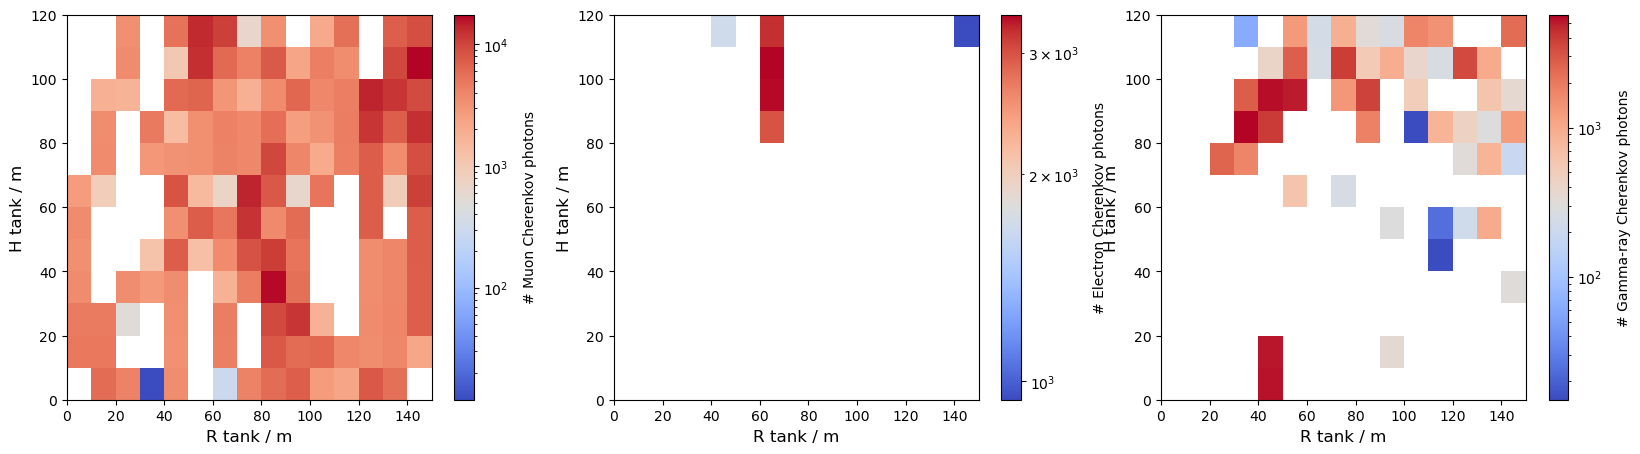

In [14]:
plt.subplots(1,3,figsize=(20,5))

plt.subplot(1,3,1)

hist_mu = plt.hist2d(photons_mu_r, photons_mu_z, bins=[r_bins,z_bins], norm=mpl.colors.LogNorm(), cmap = plt.cm.coolwarm )
plt.xlabel('R tank / m',size=12)
plt.ylabel('H tank / m',size=12)
cbar = plt.colorbar()
cbar.set_label('# Muon Cherenkov photons', rotation=90, labelpad=10)

plt.subplot(1,3,2)

hist_elec = plt.hist2d(photons_e_r, photons_e_z, bins=[r_bins,z_bins], norm=mpl.colors.LogNorm(), cmap = plt.cm.coolwarm )
plt.xlabel('R tank / m',size=12)
plt.ylabel('H tank / m',size=12)
cbar = plt.colorbar()
cbar.set_label('# Electron Cherenkov photons', rotation=90, labelpad=10)

plt.subplot(1,3,3)

hist_gamma = plt.hist2d(photons_gamma_r, photons_gamma_z, bins=[r_bins,z_bins], norm=mpl.colors.LogNorm(), cmap = plt.cm.coolwarm )
plt.xlabel('R tank / m',size=12)
plt.ylabel('H tank / m',size=12)
cbar = plt.colorbar()
cbar.set_label('# Gamma-ray Cherenkov photons', rotation=90, labelpad=10)

(12, 15)
(12, 15)
(12, 15)
(12, 15)
(12, 15)
(12, 15)


Text(0, 0.5, 'H tank / m')

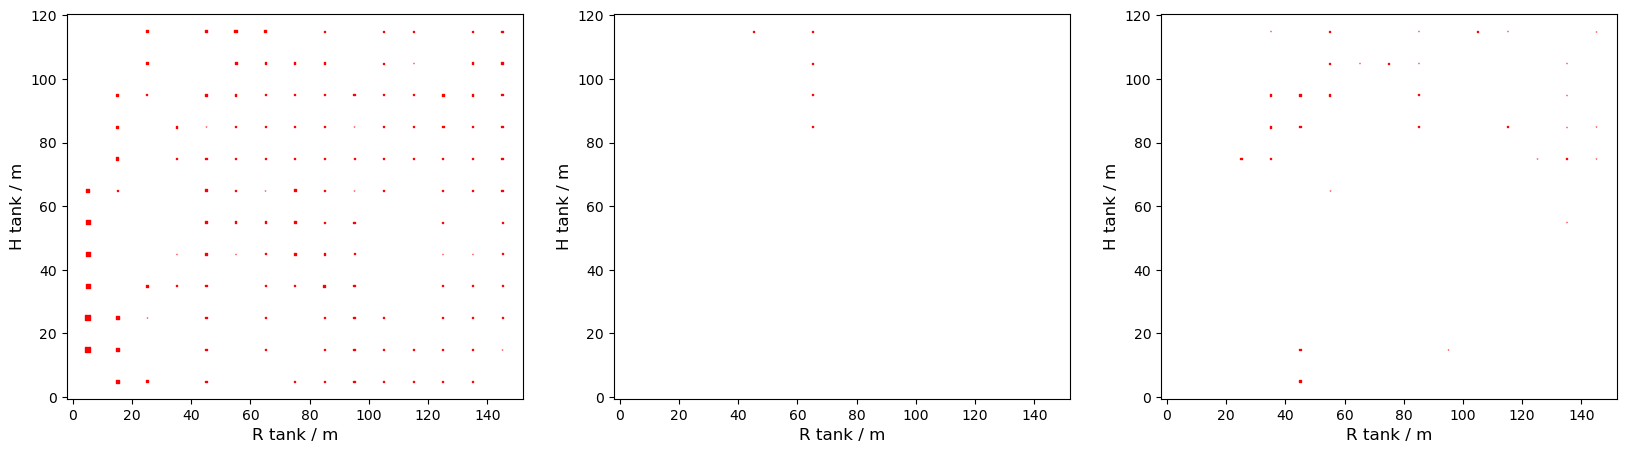

In [15]:
plt.subplots(1,3,figsize=(20,5))

plt.subplot(1,3,1)

bin_count_mu = hist_mu[0]
ph_density_mu = bin_count_mu / vol 

print(r_centers.shape)
print(z_centers.shape)

#plt.scatter(r_centers, z_centers, c = ph_density.T, marker='s')
#plt.colorbar()

plt.scatter(r_centers, z_centers, s=ph_density_mu.T*7, marker='s', c='red')
plt.xlabel('R tank / m',size=12)
plt.ylabel('H tank / m',size=12)

plt.subplot(1,3,2)

bin_count_elec = hist_elec[0]
ph_density_elec = bin_count_elec / vol 

print(r_centers.shape)
print(z_centers.shape)

#plt.scatter(r_centers, z_centers, c = ph_density.T, marker='s')
#plt.colorbar()

plt.scatter(r_centers, z_centers, s=ph_density_elec.T*7, marker='s', c='red')
plt.xlabel('R tank / m',size=12)
plt.ylabel('H tank / m',size=12)

plt.subplot(1,3,3)

bin_count_gamma = hist_gamma[0]
ph_density_gamma = bin_count_gamma / vol 

print(r_centers.shape)
print(z_centers.shape)

#plt.scatter(r_centers, z_centers, c = ph_density.T, marker='s')
#plt.colorbar()

plt.scatter(r_centers, z_centers, s=ph_density_gamma.T*7, marker='s', c='red')
plt.xlabel('R tank / m',size=12)
plt.ylabel('H tank / m',size=12)

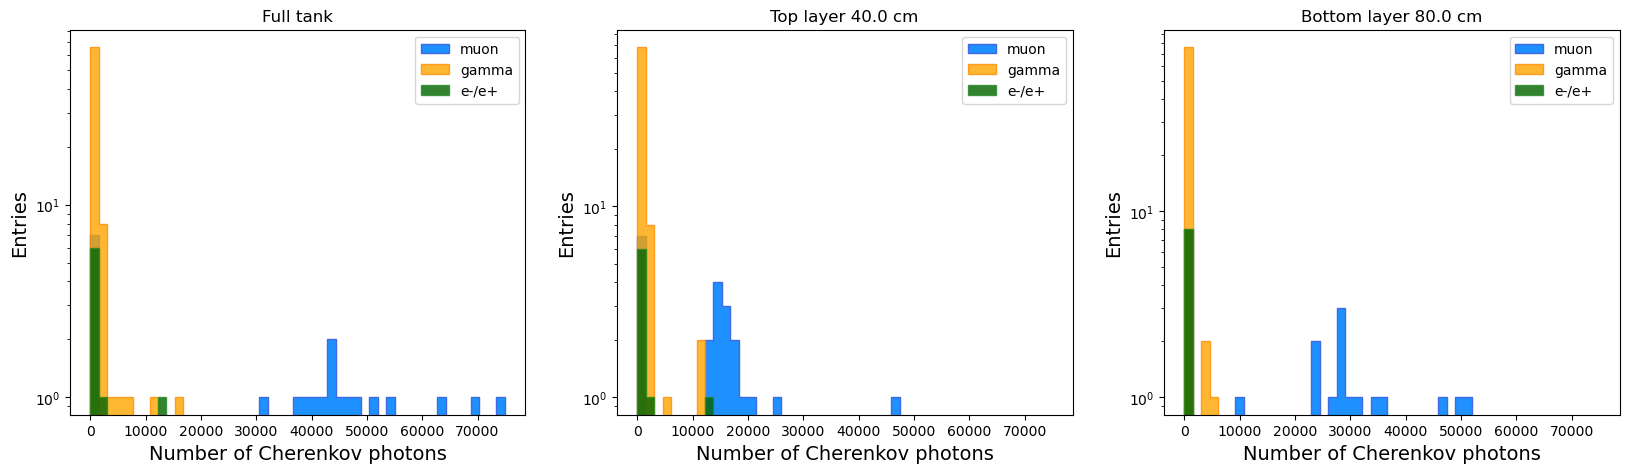

In [16]:
plt.subplots(1,3,figsize=(20,5))

plt.subplot(1,3,1)
max_photons = np.max(N_photons_mu) 
hist_bins = np.linspace(0,max_photons,50)

plt.hist(N_photons_mu, bins = hist_bins, color='dodgerblue',edgecolor='royalblue',histtype= "stepfilled", label = 'muon')
plt.hist(N_photons_gamma, bins = hist_bins, color='orange',edgecolor='darkorange',histtype= "stepfilled", alpha = 0.8, label = 'gamma')
plt.hist(N_photons_e, bins = hist_bins, color='darkgreen',edgecolor='forestgreen',histtype= "stepfilled", alpha=0.8, label = 'e-/e+')

plt.xlabel('Number of Cherenkov photons',size=14)
plt.ylabel('Entries',size=14)

plt.legend()
plt.yscale('log')

plt.title('Full tank')

plt.subplot(1,3,2)

max_photons_top = np.max(N_photons_top_mu) 
hist_top_bins = np.linspace(0,max_photons_top,50)

plt.hist(N_photons_top_mu, bins = hist_bins, color='dodgerblue',edgecolor='royalblue',histtype= "stepfilled", label = 'muon')
plt.hist(N_photons_top_gamma, bins = hist_bins, color='orange',edgecolor='darkorange',histtype= "stepfilled", alpha=0.8, label = 'gamma')
plt.hist(N_photons_top_e, bins = hist_bins, color='darkgreen',edgecolor='forestgreen',histtype= "stepfilled", alpha=0.8, label = 'e-/e+')

plt.xlabel('Number of Cherenkov photons',size=14)
plt.ylabel('Entries',size=14)

plt.legend()
plt.yscale('log')

plt.title('Top layer '+str(H_TANK-TOP_TANK))

plt.subplot(1,3,3)

max_photons_top = np.max(N_photons_top_mu) 
hist_top_bins = np.linspace(0,max_photons_top,50)

plt.hist(N_photons_bottom_mu, bins = hist_bins, color='dodgerblue',edgecolor='royalblue',histtype= "stepfilled", label = 'muon')
plt.hist(N_photons_bottom_gamma, bins = hist_bins, color='orange',edgecolor='darkorange',histtype= "stepfilled", alpha=0.8, label = 'gamma')
plt.hist(N_photons_bottom_e, bins = hist_bins, color='darkgreen',edgecolor='forestgreen',histtype= "stepfilled", alpha=0.8, label = 'e-/e+')

plt.xlabel('Number of Cherenkov photons',size=14)
plt.ylabel('Entries',size=14)

plt.legend()
plt.yscale('log')

plt.title('Bottom layer '+str(TOP_TANK))

plt.savefig('./plots/n_ch_photons_'+str(int(N_PARTICLES))+'_TOP_'+str(TOP_TANK.value)+'.pdf',format='pdf')


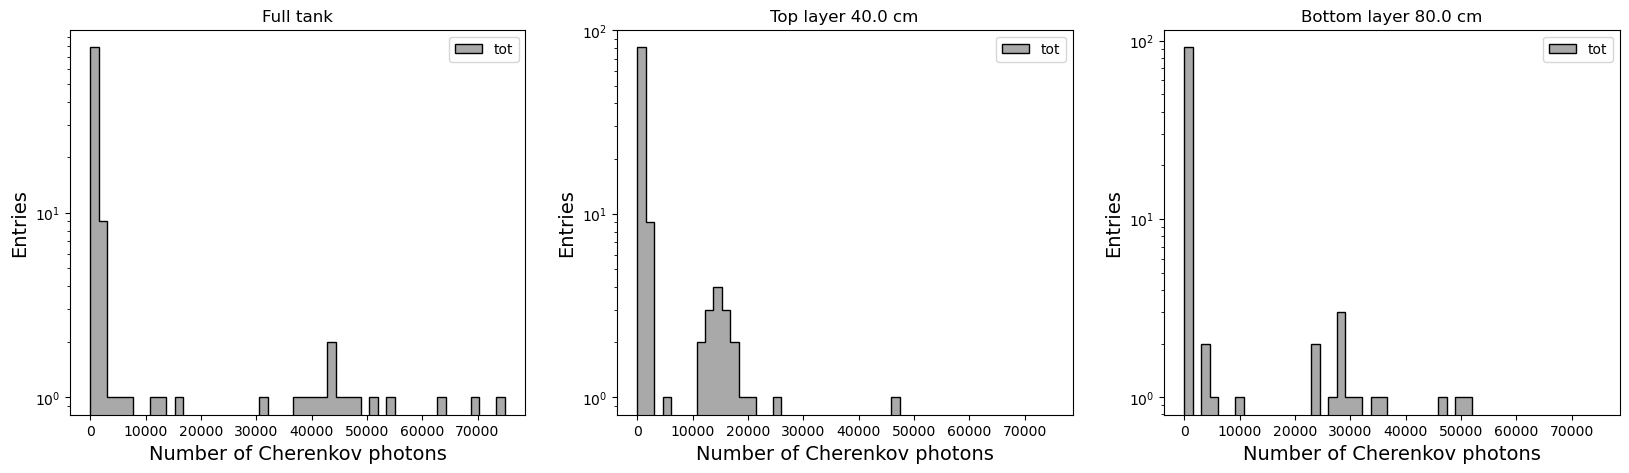

In [17]:
plt.subplots(1,3,figsize=(20,5))

plt.subplot(1,3,1)
tot_hist = plt.hist(N_photons_mu + N_photons_e + N_photons_gamma, bins = hist_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label = 'tot')
plt.yscale('log')

plt.xlabel('Number of Cherenkov photons',size=14)
plt.ylabel('Entries',size=14)

plt.legend()
plt.yscale('log')

plt.title('Full tank')

plt.subplot(1,3,2)

plt.hist(N_photons_top_mu + N_photons_top_e + N_photons_top_gamma, bins = hist_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label = 'tot')
plt.yscale('log')

plt.xlabel('Number of Cherenkov photons',size=14)
plt.ylabel('Entries',size=14)

plt.legend()
plt.yscale('log')

plt.title('Top layer '+str(H_TANK-TOP_TANK))

plt.subplot(1,3,3)

plt.hist(N_photons_bottom_mu + N_photons_bottom_e + N_photons_bottom_gamma, bins = hist_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label = 'tot')
plt.yscale('log')

plt.xlabel('Number of Cherenkov photons',size=14)
plt.ylabel('Entries',size=14)

plt.legend()
plt.yscale('log')

plt.title('Bottom layer '+str(TOP_TANK))

plt.savefig('./plots/n_ch_photons_tot_'+str(int(N_PARTICLES))+'_TOP_'+str(TOP_TANK.value)+'.pdf',format='pdf')


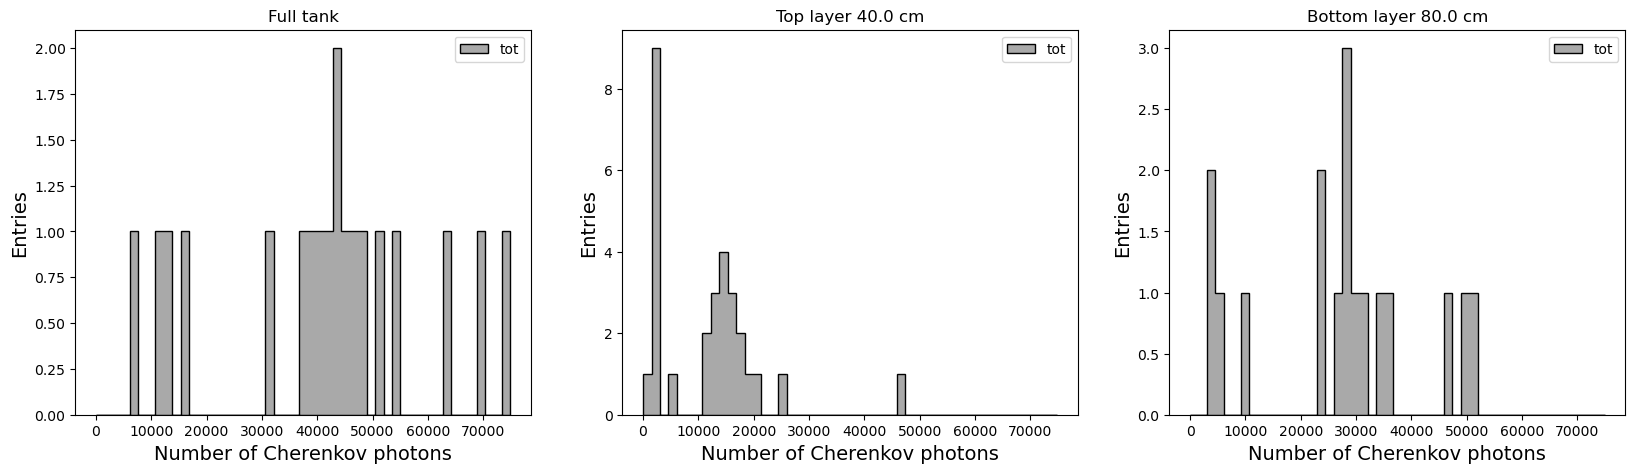

In [18]:
plt.subplots(1,3,figsize=(20,5))
All_photons = np.asarray(N_photons_mu + N_photons_e + N_photons_gamma)
All_photons = All_photons[All_photons > 5000]

plt.subplot(1,3,1)
tot_hist = plt.hist(All_photons, bins = hist_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label = 'tot')

plt.xlabel('Number of Cherenkov photons',size=14)
plt.ylabel('Entries',size=14)

plt.legend()

plt.title('Full tank')

plt.subplot(1,3,2)

All_photons_top = np.asarray(N_photons_top_mu + N_photons_top_e + N_photons_top_gamma)
All_photons_top = All_photons_top[All_photons_top > 1000]

plt.hist(All_photons_top, bins = hist_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label = 'tot')

plt.xlabel('Number of Cherenkov photons',size=14)
plt.ylabel('Entries',size=14)

plt.legend()

plt.title('Top layer '+str(H_TANK-TOP_TANK))

plt.subplot(1,3,3)
All_photons_bottom = np.asarray(N_photons_bottom_mu + N_photons_bottom_e + N_photons_bottom_gamma)
All_photons_bottom = All_photons_bottom[All_photons_bottom > 1000]


plt.hist(All_photons_bottom, bins = hist_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label = 'tot')

plt.xlabel('Number of Cherenkov photons',size=14)
plt.ylabel('Entries',size=14)

plt.legend()

plt.title('Bottom layer '+str(TOP_TANK))

plt.savefig('./plots/n_ch_photons_tot_'+str(int(N_PARTICLES))+'_TOP_'+str(TOP_TANK.value)+'_lin.pdf',format='pdf')


22
8
70
79
Sum check:  100


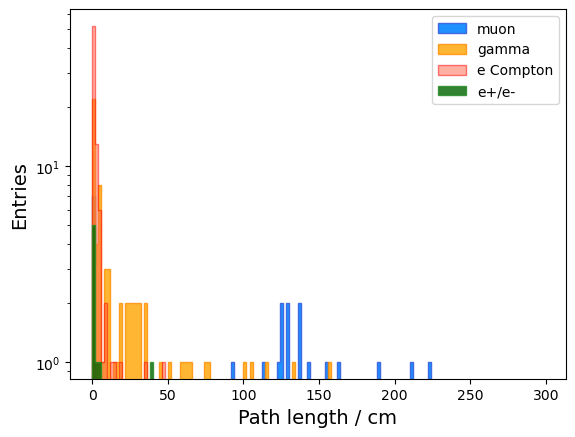

In [19]:
print(len(path_length_muon))
print(len(path_length_e))
print(len(path_length_gamma))
print(len(path_length_e_Compton))
print('Sum check: ',len(path_length_muon)+len(path_length_e)+len(path_length_gamma))

l_muon = np.asarray(path_length_muon).flatten()
l_e = np.asarray(path_length_e).flatten()
l_gamma = np.asarray(path_length_gamma).flatten()
l_e_compton = np.asarray(path_length_e_Compton).flatten()

l_bins = np.arange(0,300,2)

plt.hist(l_muon, bins = l_bins, color='dodgerblue',edgecolor='royalblue',histtype= "stepfilled", label = 'muon')
plt.hist(l_gamma, bins = l_bins, color='orange',edgecolor='darkorange',histtype= "stepfilled", alpha=0.8, label = 'gamma' )
plt.hist(l_e_compton, bins = l_bins, color='tomato',edgecolor='red',histtype= "stepfilled", alpha=0.5, label = 'e Compton')
plt.hist(l_e, bins = l_bins, color='darkgreen',edgecolor='forestgreen',histtype= "stepfilled", alpha=0.8, label = 'e+/e-')

plt.xlabel('Path length / cm', size = 14)
plt.ylabel('Entries', size = 14)
plt.yscale('log')
plt.legend()

plt.savefig('./plots/path_length_'+str(int(N_PARTICLES))+'_TOP_'+str(TOP_TANK.value)+'.pdf',format='pdf')


In [20]:
# Extract coordinates of all the produced Cherenkov photons
photons_mu_x = np.asarray([ph_coor[0].value for ph_coor in photons_mu_coor])
photons_mu_y = np.asarray([ph_coor[1].value for ph_coor in photons_mu_coor])
photons_mu_z = np.asarray([ph_coor[2].value for ph_coor in photons_mu_coor])


In [21]:
# Extract coordinates of all the produced Cherenkov photons
photons_e_x = np.asarray([e_ph_coor[0].value for e_ph_coor in photons_e_coor])
photons_e_y = np.asarray([e_ph_coor[1].value for e_ph_coor in photons_e_coor])
photons_e_z = np.asarray([e_ph_coor[2].value for e_ph_coor in photons_e_coor])

In [22]:
# Extract coordinates of all the produced Cherenkov photons
photons_gamma_x = np.asarray([gamma_ph_coor[0].value for gamma_ph_coor in photons_gamma_coor])
photons_gamma_y = np.asarray([gamma_ph_coor[1].value for gamma_ph_coor in photons_gamma_coor])
photons_gamma_z = np.asarray([gamma_ph_coor[2].value for gamma_ph_coor in photons_gamma_coor])

In [23]:
print(len(photons_mu_z))
print(len(photons_e_z))
print(len(photons_gamma_z))


728853
15592
75750


In [24]:
# Save data in a h5 file 
import h5py

hf = h5py.File('./output/Cherenkov_photons'+str(int(N_PARTICLES))+'.h5','w')
hf.create_dataset('photons_mu_x', data=photons_mu_x, compression="gzip",compression_opts=3)
hf.create_dataset('photons_mu_y', data=photons_mu_y, compression="gzip",compression_opts=3)
hf.create_dataset('photons_mu_z', data=photons_mu_z, compression="gzip",compression_opts=3)
hf.create_dataset('mu_number', data=mu_number, compression="gzip",compression_opts=3)

hf.create_dataset('photons_e_x', data=photons_e_x, compression="gzip", compression_opts=3)
hf.create_dataset('photons_e_y', data=photons_e_y, compression="gzip", compression_opts=3)
hf.create_dataset('photons_e_z', data=photons_e_z, compression="gzip", compression_opts=3)
hf.create_dataset('e_number', data=e_number)

hf.create_dataset('photons_gamma_x', data=photons_gamma_x, compression="gzip", compression_opts=3)
hf.create_dataset('photons_gamma_y', data=photons_gamma_y, compression="gzip", compression_opts=3)
hf.create_dataset('photons_gamma_z', data=photons_gamma_z, compression="gzip", compression_opts=3)
hf.create_dataset('gamma_number', data=gamma_number, compression="gzip", compression_opts=3)

hf.close()


In [25]:
len(photons_e_x)

15592

In [26]:
mask_number = 32
mu_number_mask = (mu_number == mu_number[mask_number])

e_number_mask = (e_number == e_number[mask_number])

In [27]:
# Define coordinates of PMT 
pmt_coor = [0,0,80] # cm 

# Compute distance between photons produced from 0 to 80 cm on z axis to the PMT 
bottom_tank_mask = photons_mu_z[mu_number_mask] < 80

In [28]:
from scipy.constants import c 
c = c * u.m / u.s
c.to(u.cm/u.s)

<Quantity 2.99792458e+10 cm / s>

In [29]:
dist_photons_pmt = np.sqrt( photons_mu_x[mu_number_mask]**2 + photons_mu_y[mu_number_mask]**2 + (photons_mu_z[mu_number_mask] - pmt_coor[2])**2 )
time_direct_photons_pmt = dist_photons_pmt / (water.n * c.to(u.cm/u.s).value)

In [30]:
tau = 60 * 1e-9 #ns 
exp_time = np.random.exponential(tau, size=len(time_direct_photons_pmt))
time_photons_pmt = time_direct_photons_pmt + exp_time

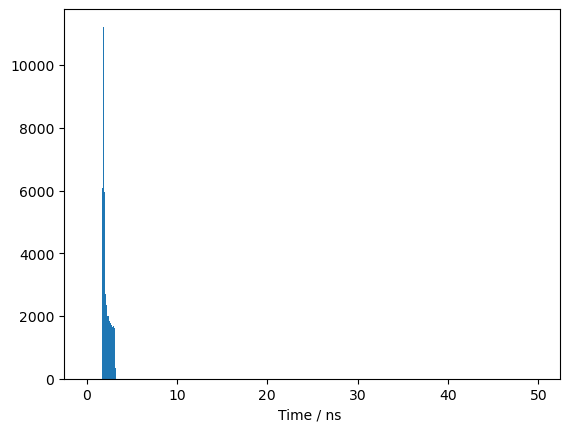

In [31]:
plt.hist(time_direct_photons_pmt*1e9,bins=np.arange(0,50,0.1))
plt.xlabel('Time / ns ')
plt.yscale('linear')

Peak value:  6059.0
Integral value:  45026.0


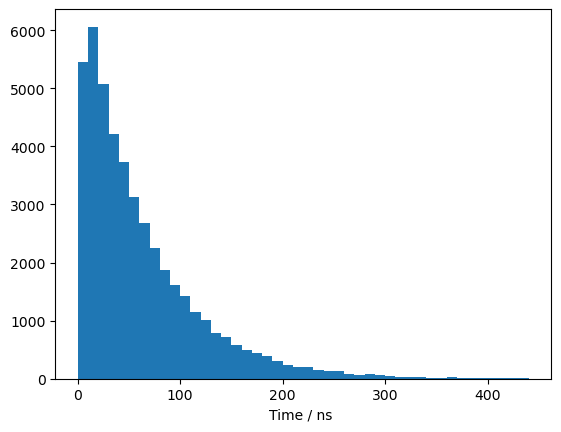

In [32]:
counts, bin_edges, fig = plt.hist(time_photons_pmt*1e9,bins=np.arange(0,450,10))
plt.xlabel('Time / ns ')
plt.yscale('linear')

max_counts = np.max(counts)
tot_counts = np.sum(counts)

print("Peak value: ", max_counts)
print("Integral value: ",tot_counts)

In [33]:
dist_e_photons_pmt = np.sqrt( photons_e_x[e_number_mask]**2 + photons_e_y[e_number_mask]**2 + (photons_e_z[e_number_mask] - pmt_coor[2])**2 )
time_direct_e_photons_pmt = dist_e_photons_pmt / (water.n * c.to(u.cm/u.s).value)
exp_time_e = np.random.exponential(tau, size=len(time_direct_e_photons_pmt))

time_e_photons_pmt = time_direct_e_photons_pmt + exp_time_e

Peak value:  134.0
Integral value:  938.0


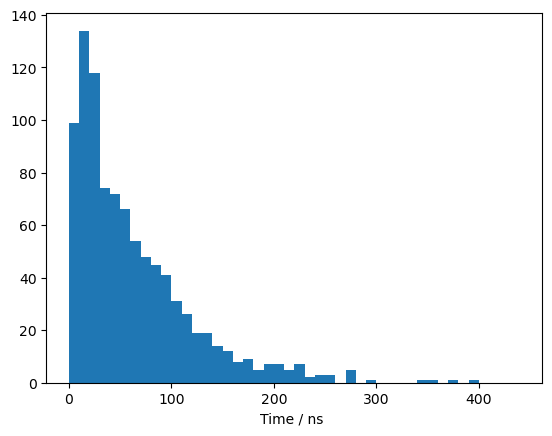

In [34]:
counts, bin_edges, fig = plt.hist(time_e_photons_pmt*1e9,bins=np.arange(0,450,10))
plt.xlabel('Time / ns ')
plt.yscale('linear')

max_counts = np.max(counts)
tot_counts = np.sum(counts)

print("Peak value: ", max_counts)
print("Integral value: ",tot_counts)